In [1]:
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer as Trainer
import ray.rllib.agents.ppo.ppo as ppo
from ray.tune.logger import pretty_print

print(ray.__version__)
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy

import qsd_library_last as qsdl

# Common parameters for all runs
num_gpus = 0.25
num_workers = 4
ray_init_kwargs = {"object_store_memory": 5*1024**3, "num_cpus": num_workers+1}

0.7.3


In [ ]:
def U(eps):
    return np.array([[np.cos(eps*np.pi), -np.sin(eps*np.pi)],[np.sin(eps*np.pi), np.cos(eps*np.pi)]])

def rhor(rho, eps):
    for j in range(len(rho)):
        for k in range(len(rho[j])):
            rho[j][k] = U(eps)@rho[j][k]@np.transpose(U(eps))
    return rho

total_trials = 3
training_trials = 100
evaluation_trials = 5000
d = 2*np.ones(3)
m = 3
q = np.array([1/3, 1/3, 1/3])
lr = 0.00005

eps_vec = [0, 0.001, 0.005, 0.01, 0.05, 0.075, 0.1, 0.2]
pvec = np.zeros((total_trials, len(eps_vec)))

for k in range(total_trials):
    rho, _ = qsdl.generate_initial_state(d, m, True)

    defaultconfig = {"rho": copy.copy(rho), "q": copy.copy(q),  
                 "quantization" : 20, "d" : d, "separable": True}
    
    ray.shutdown()
    ray.init(**ray_init_kwargs)
    config = ppo.DEFAULT_CONFIG.copy()
    if (num_gpus > 0):
        config["num_gpus"] = num_gpus
    config["num_workers"] = num_workers
    config["lr"] = lr
    config["train_batch_size"] = 8000
    config["num_sgd_iter"] = 5
    config["env_config"] = defaultconfig
    trainer = Trainer(config=config, env=qsdl.QSDEnv)
    for i in range(training_trials):
        result = trainer.train()
        print("train iteration",i+1,"/",training_trials," avg_reward =", 
            result["episode_reward_mean"]," timesteps =", result["timesteps_total"])

    for _ in range(len(eps_vec)):    
        rew = 0
        rhon = rhor(copy.copy(rho), eps_vec[_])
        defaultconfig = {"rho": copy.copy(rhon), "q": copy.copy(q),  
                 "quantization" : 20, "d" : d, "separable": True}
        for i in range(evaluation_trials):
            env=qsdl.QSDEnv(defaultconfig)
            obs = env.reset()
            done = False
            while not done:
                action = trainer.compute_action(obs)
                obs, r, done, nn = env.step(action)
                rew += r
        pvec[k][_] = rew/evaluation_trials
        print(pvec)

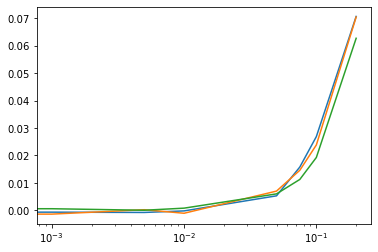

In [8]:
import tikzplotlib as tikz
for k in range(total_trials):
    plt.plot(eps_vec, np.ones(len(eps_vec))*pvec[k][0]-pvec[k])
plt.xscale("log")
tikz.save('noiseplot')
plt.show()